## Comparison of GloGEM, PyGEM, and OGGM RGI 11 Runoff Outputs 

Based on the 9 June 2023 version of [this work](https://github.com/finnwimberly/glacial_runoff_intercomparison/blob/main/CE_GloPyOG_AggregateBasinComp.ipynb) by Finn Wimberly.

This notebook imports and processes GloGEM, PyGEM, and OGGM RGI 11 outputs. Summing glacial runoff by basin, we produce a plot that compares the three models' projected runoff values for each basin by SSP. We also compare the portion of runoff that comes directly from glacier mass loss according to each model.

Last Updated: 15 June 2023 | EHU

### Aggregation of GloGEM runoff:

In [261]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import date
import collections
import datetime
import itertools
import json
import os


## Generic the filepath to the main data folder
fpath_glogem = '/Volumes/GoogleDrive/My Drive/Runoff-intercomparison/GloGEM-output/RGI11-CentralEurope/files/'

#All of the climate models used
modelnames = ['BCC-CSM2-MR','CAMS-CSM1-0','CESM2','CESM2-WACCM','EC-Earth3','EC-Earth3-Veg','FGOALS-f3-L','GFDL-ESM4',
              'INM-CM4-8','INM-CM5-0','MPI-ESM1-2-HR','MRI-ESM2-0']

SSPpaths = ['ssp126','ssp245','ssp370','ssp585']   #Specifiying the SSP
#SSPs = ['ssp119','ssp126','ssp245','ssp370','ssp585'] #Use a different path as we have all 5 ssps for volume

In [262]:
all_discharges = [[] for _ in SSPpaths]

for s, SSPpath in enumerate(SSPpaths):
    model_discharges = []
    for modelname in modelnames:
        temp_df = pd.read_csv(fpath_glogem + modelname + '/' + SSPpaths[s]  + '/' + 'centraleurope_Discharge_r1.dat', sep='\s+', header=None, skiprows=1, index_col=0)
        model_discharges.append(temp_df)
    all_discharges[s] = model_discharges

In [263]:
all_areas = [[] for _ in SSPpaths]

for s, SSPpath in enumerate(SSPpaths):
    model_areas = []
    for modelname in modelnames:
        temp_df = pd.read_csv(fpath_glogem + modelname  + '/' + SSPpaths[s]  + '/' + 'centraleurope_Area_r1.dat', sep='\s+', index_col="ID")
        model_areas.append(temp_df)
    all_areas[s] = model_areas

In [264]:
# Create new index using pandas date_range function
start_date = datetime.date(1980, 1, 1)
end_date = datetime.date(2100, 12, 1)
new_indices = pd.date_range(start_date, end_date, freq='MS').strftime('%Y-%m').tolist()

# Apply new index and datetime conversion
for s, SSPpath_discharges in enumerate(all_discharges):
    for m, discharge_df in enumerate(SSPpath_discharges):
        all_discharges[s][m].columns = new_indices
        all_discharges[s][m].columns = pd.to_datetime(new_indices)

In [265]:
#expanding area dataset to match year-month dimension
for s in range(len(SSPpaths)):
    for i in range(len(all_areas[s])):
        all_areas[s][i] = all_areas[s][i][all_areas[s][i].columns.repeat(12)]
        
for s, areas in enumerate(all_areas):
    for i, area in enumerate(areas):
        all_areas[s][i].columns = new_indices
        all_areas[s][i].columns = pd.to_datetime(new_indices)

In [266]:
# We will use our initial area to compute runoff so we fill entire dfs with element 0
# We only use one SSP because the initial areas are all the same -- we save time without looping through all
# We also convert km^2 to m^2

initial_areas = [pd.DataFrame(df.iloc[:, 0].values.repeat(df.shape[1]).reshape(df.shape), index=df.index, columns=df.columns).mul(1e6) for df in all_areas[0]]

In [267]:
runoff = {s: {m: None for m in modelnames} for s in SSPpaths} # create nested dictionary indexed by model name and ssp
n=0
for s in SSPpaths:
    i=0
    for m in modelnames:
        runoff[s][m] = pd.concat([initial_areas[i] * all_discharges[n][i]], axis=1)
        i+=1
    n+=1

In [268]:
annualrunoff = {s: {m: None for m in modelnames} for s in SSPpaths}
for s, m in itertools.product(SSPpaths, modelnames):
    annualrunoff[s][m] = runoff[s][m].transpose().resample('A').sum()

In [269]:
def select_glaciers_json(basin='all'):
    '''
    Select glaciers within a basin by MRBID from a json-file,
    which is stored in the data directory.

    Args:
    -----
    basin: str
        String of MRBID or 'all'.

    Returns:
    --------
    If basin is 'all' a list of all relevant glaciers is returned, for
    initiating glacier simulations. If basin is a MRBID the list of glaciers
    within that basin is returned.
    
    Copy of a function written by Erik Holmgren (2022) in holmgren_gha.utils
    '''

    fpath = '/Users/lizz/Documents/Research/Runoff-intercomparison/msc_thesis-multi_gcm/code/data/rgi_ids_per_basin.json' ## correct for local run
    with open(fpath) as f:
        basin_dict = json.load(f)

    if basin.lower() != 'all':
        glacier_list = basin_dict[basin]
    else:
        glacier_list = list(itertools.chain.from_iterable(basin_dict.values()))

    return glacier_list

In [270]:
def sum_basin(basin_RGI_list, runoff_data):
    # Create new list to match our RGI formatting
    new_basin_list = [int(str(x)[-4:]) for x in basin_RGI_list]
    runoff_data = runoff_data.transpose()
    
    #TODO: create list of glaciers within a basin that are not included in GloGEM output
    # Filter new_basin_list to keep only the indexes present in the DataFrame
    new_basin_list = [x for x in new_basin_list if x in runoff_data.index]
    
    # Extract glaciers contained in the list from original df and create a new df
    new_df = runoff_data.loc[new_basin_list].copy()
    
    # Sum the values of the glaciers within the basin
    summed_basin_runoff = new_df.sum()
    #print(summed_basin_runoff)
    
    return summed_basin_runoff

In [271]:
#Generating the aggregated basin data
alpine_basins = {'RHINE':'6242', 'RHONE':'6243','PO':'6241', 'DANUBE':'6202'} ## GRDC Major River Basin identifiers for the 4 alpine basins we can study
modelnames_glo = ['BCC-CSM2-MR','CAMS-CSM1-0','CESM2','CESM2-WACCM','EC-Earth3','EC-Earth3-Veg','FGOALS-f3-L','GFDL-ESM4',
              'INM-CM4-8','INM-CM5-0','MPI-ESM1-2-HR','MRI-ESM2-0']

Rhone_runoff = {s: {m: None for m in modelnames_glo} for s in SSPpaths} # create nested dictionary indexed by model name and ssp
Rhine_runoff = {s: {m: None for m in modelnames_glo} for s in SSPpaths} 
Po_runoff = {s: {m: None for m in modelnames_glo} for s in SSPpaths}
Danube_runoff = {s: {m: None for m in modelnames_glo} for s in SSPpaths} 

for s in SSPpaths:
    for m in modelnames_glo:
        Rhone_runoff[s][m] = sum_basin(select_glaciers_json(alpine_basins['RHONE']), annualrunoff[s][m]) * 1e-9    #m^3 to km^3
        Rhine_runoff[s][m] = sum_basin(select_glaciers_json(alpine_basins['RHINE']), annualrunoff[s][m]) * 1e-9
        Po_runoff[s][m] = sum_basin(select_glaciers_json(alpine_basins['PO']), annualrunoff[s][m]) * 1e-9
        Danube_runoff[s][m] = sum_basin(select_glaciers_json(alpine_basins['DANUBE']), annualrunoff[s][m]) * 1e-9

In [272]:
#A quick redefinition that will match PyGEM formatting and make plotting easier later
basins = ['RHINE', 'RHONE', 'PO','DANUBE']
basin_sums_glo = {s: {b: {} for b in basins} for s in SSPpaths}

for s in SSPpaths:
    for m in modelnames_glo:
        basin_sums_glo[s]['RHINE'][m] = Rhine_runoff[s][m]
        basin_sums_glo[s]['RHONE'][m] = Rhone_runoff[s][m]
        basin_sums_glo[s]['PO'][m] = Po_runoff[s][m]
        basin_sums_glo[s]['DANUBE'][m] = Danube_runoff[s][m]

#To calculate multi GCM means and Quartiles we convert to df then calculate across first axis (GCMs)
GCM_mean_glo = {}
GCM_q1_glo = {}
GCM_q3_glo = {}
for SSP in SSPpaths:
    GCM_mean_glo[SSP] = {}
    GCM_q1_glo[SSP] = {}
    GCM_q3_glo[SSP] = {}
    for b in basins:
        GCM_mean_glo[SSP][b] = pd.DataFrame(basin_sums_glo[s][b]).mean(axis=1)
        GCM_q1_glo[SSP][b] = pd.DataFrame(basin_sums_glo[s][b]).quantile(q=0.25, axis=1)
        GCM_q3_glo[SSP][b] = pd.DataFrame(basin_sums_glo[s][b]).quantile(q=0.75, axis=1)

### Aggregation of PyGEM runoff:

In [273]:
import xarray as xr

#All of the climate models used
modelnames_py = ['BCC-CSM2-MR','CESM2','CESM2-WACCM','EC-Earth3','EC-Earth3-Veg','FGOALS-f3-L','GFDL-ESM4',
              'INM-CM4-8','INM-CM5-0','MPI-ESM1-2-HR','MRI-ESM2-0', 'NorESM2-MM']

SSPs = ['ssp126','ssp245','ssp370','ssp585'] #List of all SSPs in PyGEM
which_ssp = SSPs[0]

alpine_basins = {'RHINE': '6242',
                 'RHONE': '6243',
                 'PO': '6241',
                 'DANUBE':'6202'} ## GRDC Major River Basin identifiers for the 4 alpine basins we can study

test_basin = alpine_basins['RHONE'] 

#Generic filepath to navigate to Drive folder 
fpathPy = '/Volumes/GoogleDrive/My Drive/Runoff-intercomparison/PyGEM/11'

In [274]:
basin_gls = {}
for basin, code in alpine_basins.items():
    basin_gls[basin] = select_glaciers_json(code)

In [275]:
#Importing all runoff data, taking annual sum, and converting m^3 to km^3
import glob   #use glob to group files by filename similarities (in this case, SSP)

rf_ds = {}
annual_rf_ds = {}
for s, SSP in enumerate(SSPs):
    fpath1 = '/R11_runoff_monthly_c2_ba1_1set_2000_2100-{}'.format(SSP)
    file_pattern = f'{fpathPy + fpath1}*.nc'
    file_list = glob.glob(file_pattern)
    
    datasets = []  # Create an empty list for each SSP
    if file_list:
        for file in file_list:
            with xr.open_dataset(file) as ds:
                ds = ds.glac_runoff_monthly.load()
                datasets.append(ds)
    
        combined_ds = xr.concat(datasets, dim='glacier')  # Concatenate the datasets
        rf_ds[SSP] = combined_ds
        annual_rf_ds[SSP] = rf_ds[SSP].resample(time='A').sum() * 1e-9

In [276]:
# Sorting into basins
basin_datasets = {}
for basin, glacier_list in basin_gls.items():
    ## loop over them all, drop the irrelevant IDs, and concatenate the result
    basin_datasets[basin] = {}
    for s, SSP in enumerate(SSPs):
        ds_list = []
        try:
            ds_filtered = annual_rf_ds[SSP].where(annual_rf_ds[SSP].RGIId.isin(glacier_list), drop=True)
            #print(ds_filtered)
            ds_list.append(ds_filtered)
        except ValueError: ## happens if there are no glaciers from this batch in the selected region
            continue
        basin_datasets[basin][SSP] = xr.concat(ds_list, dim='glacier')

In [277]:
#Flipping indexing (to match other models) and summing basins
basin_sums_py = {}
for s, SSP in enumerate(SSPs):        
    basin_sums_py[SSP] = {}
    for basin, glacier_list in basin_gls.items():
        basin_sums_py[SSP][basin] = basin_datasets[basin][SSP].sum(dim='glacier')

In [278]:
#Compute multi GCM means and quartiles
GCM_mean_py = {}
GCM_q1_py = {}
GCM_q3_py = {}
for s, SSP in enumerate(SSPs):
    which_ssp = SSPs[s]
    GCM_mean_py[which_ssp] = {}
    GCM_q1_py[which_ssp] = {}
    GCM_q3_py[which_ssp] = {}
    for basin in basins:
        GCM_mean_py[which_ssp][basin] = basin_sums_py[which_ssp][basin].mean(dim = 'model')
        GCM_q1_py[which_ssp][basin] = basin_sums_py[which_ssp][basin].quantile(q = 0.25, dim = 'model')
        GCM_q3_py[which_ssp][basin] = basin_sums_py[which_ssp][basin].quantile(q = 0.75, dim = 'model')

### Introducing OGGM Runoff

In [279]:
#All of the climate models used
modelnames_OG = ['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2', 'CESM2-WACCM', 'CMCC-CM2-SR5','EC-Earth3', 'EC-Earth3-Veg', 'FGOALS-f3-L', 'GFDL-ESM4', 'INM-CM4-8',
               'INM-CM5-0', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorESM2-MM', 'TaiESM1']

# CMCC-CM2-SR5 & TaiESM1 only hold values for ssp585––this is model list without those GCMS
modelnames_OG_trimmed = ['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2', 'CESM2-WACCM', 'EC-Earth3', 'EC-Earth3-Veg', 'FGOALS-f3-L', 'GFDL-ESM4', 'INM-CM4-8',
               'INM-CM5-0', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorESM2-MM']

#Generic filepath to navigate to Drive folder 
fpathOG = '/Volumes/GoogleDrive/My Drive/Runoff-intercomparison/OGGM/'

In [280]:
#Importing all runoff data, OGGM is grouped by basin
rf_ds = {}
for basin, code in alpine_basins.items():
    fpath_basin = 'lschuster/{}'.format(code)
    #print(f'{fpathOG + fpath_basin} (1)/*.nc')
    with xr.open_mfdataset(f'{fpathOG + fpath_basin}/*.nc') as ds:
        ds = ds.runoff.load()
    rf_ds[basin] = ds

In [281]:
#Summing individual glacier runoff into basin totals and converting kg to km^3
basin_rf_OG = {}
for basin, code in alpine_basins.items():
    basin_rf_OG[basin] = rf_ds[basin].sum(dim = 'rgi_id') * 1e-12

In [282]:
#creating dict of GloPy format
basins = ['RHINE', 'RHONE', 'PO', 'DANUBE']
basin_sums_OG = {}
for s, SSP in enumerate(SSPs):
    which_ssp = SSPs[s]
    basin_sums_OG[which_ssp] = {}
    for b, basin in enumerate(basins):
        basin_sums_OG[which_ssp][basin] = basin_rf_OG[basin].sel(scenario = which_ssp)

In [283]:
#Plotting it looks like some GCMs contain all-zero values, like:
basin_sums_OG['ssp126']['DANUBE'][14]

<xarray.DataArray 'runoff' (time: 101)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)
Coordinates:
  * time             (time) float64 2e+03 2.001e+03 ... 2.099e+03 2.1e+03
    scenario         <U6 'ssp126'
    gcm              <U7 'TaiESM1'
    hydro_year       (time) int64 2000 2001 2002 2003 ... 2097 2098 2099 2100
    hydro_month      (time) int64 4 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4 4
    calendar_year    (time) int64 2000 2001 2002 2003 ... 2097 2098 2099 2100
    calendar_month   (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    bias_correction  <U12 'bc_2000_2019'

In [284]:
#Removing these GCMs for ALL SSPs--doing even 585 as these two are not included...
#... in Glo or Py so not only makeds OOGM easier but maintains GCM consistency in analysis
trimmed_basin_sums_OG = {}
for s, SSP in enumerate(SSPs):
    which_ssp = SSPs[s]
    trimmed_basin_sums_OG[which_ssp] = {}
    for b, basin in enumerate(basins):
        trimmed_basin_sums_OG[which_ssp][basin] = xr.concat([basin_sums_OG[which_ssp][basin][0:4], basin_sums_OG[which_ssp][basin][5:-1]], dim='gcm')

In [285]:
#Compute multi GCM means and quartiles for OGGM
GCM_mean_OG = {}
GCM_q1_OG = {}
GCM_q3_OG = {}
for s, SSP in enumerate(SSPs):
    which_ssp = SSPs[s]
    GCM_mean_OG[which_ssp] = {}
    GCM_q1_OG[which_ssp] = {}
    GCM_q3_OG[which_ssp] = {}
    for basin in basins:
        GCM_mean_OG[which_ssp][basin] = trimmed_basin_sums_OG[which_ssp][basin].mean(dim = 'gcm')
        GCM_q1_OG[which_ssp][basin] = trimmed_basin_sums_OG[which_ssp][basin].quantile(q = 0.25, dim = 'gcm')
        GCM_q3_OG[which_ssp][basin] = trimmed_basin_sums_OG[which_ssp][basin].quantile(q = 0.75, dim = 'gcm')

In [286]:
#Plot setup
from cycler import cycler
import matplotlib.patches as mpatches

scenarios = ['ssp126','ssp245','ssp370','ssp585']
basins = ['RHINE', 'RHONE', 'PO','DANUBE']
basinstext = ['Rhine', 'Rhone', 'Po','Danube']

yrs_glo = np.arange(1980,2101)
yrs_glo_dt = pd.to_datetime([str(y)for y in yrs_glo])

colors_glo =  plt.colormaps['Greens']
line_colors_glo = colors_glo(np.linspace(0.2, 0.6, num = 12))
glo_cycler = cycler(color = line_colors_glo)

colors_py =  plt.colormaps['Purples']
line_colors_py = colors_py(np.linspace(0.2, 0.6,num = 12))
py_cycler = cycler(color = line_colors_py)

colors_OG =  plt.colormaps['Blues']
line_colors_OG = colors_OG(np.linspace(0.2, 0.6,num = 12))
OG_cycler = cycler(color = line_colors_OG)

In [287]:
#Correct for GloGEM hydro vs regular year indexing???
start_date = datetime.date(1979, 10, 1)
end_date = datetime.date(2100, 9, 1)
yrs = pd.date_range(start_date, end_date, freq='MS')

Text(-1.3, 4.66, 'SSP 126                                 SSP 245                                SSP 370                                 SSP 585')

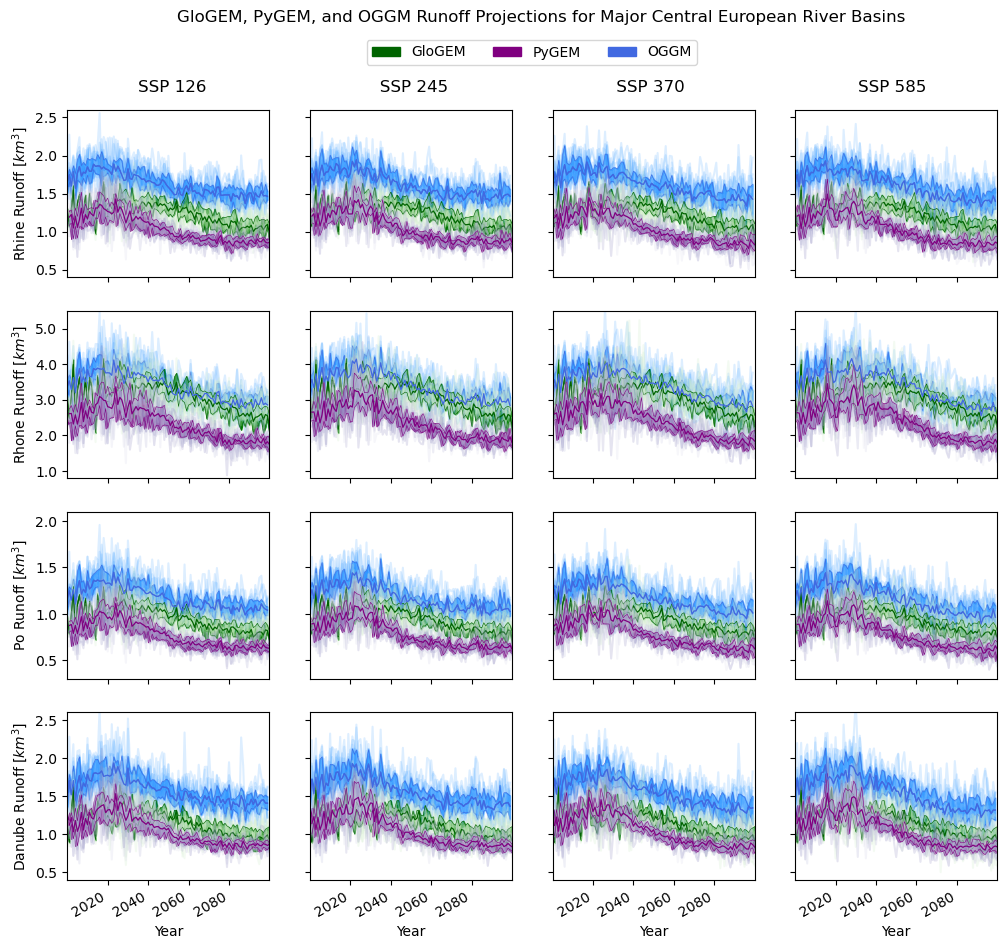

In [288]:
#Same plot as above with OGGM data added
#Also flipping axes so that l to r reads as one basin with increasing scenario severity 
#Plotting all data
fig, axs = plt.subplots(len(scenarios), 4, figsize=(12, 10), sharex=True, sharey='row')
for s, SSP in enumerate(scenarios):
    which_ssp = SSPs[s]
    for b, basin in enumerate(basins):

        #OG won't plot with built-in ds.plot()
        #Trim last value as it goes to zero
        for m, model in enumerate(modelnames_OG_trimmed):
            axs[b,s].plot(yrs_glo_dt[20:-1], trimmed_basin_sums_OG[which_ssp][basin][:,0:-1].sel(gcm = modelnames_OG_trimmed[m]), color = 'dodgerblue', alpha = 0.15)
        axs[b,s].plot(yrs_glo_dt[20:-1], GCM_mean_OG[which_ssp][basin][0:-1], color = 'royalblue', linewidth = 0.9)
        axs[b,s].plot(yrs_glo_dt[20:-1], GCM_q1_OG[which_ssp][basin][0:-1], color = 'royalblue', linewidth = 0.4)
        axs[b,s].plot(yrs_glo_dt[20:-1], GCM_q3_OG[which_ssp][basin][0:-1], color = 'royalblue', linewidth = 0.4)
        axs[b,s].fill_between(yrs_glo_dt[20:-1], GCM_q1_OG[which_ssp][basin][0:-1], GCM_q3_OG[which_ssp][basin][0:-1], color = 'dodgerblue', alpha = 0.5)

        #Trim first value as it is incomplete hydrological year
        for m in modelnames_glo:
            axs[b, s].plot(yrs_glo_dt, basin_sums_glo[which_ssp][basin][m], color=axs[b, s].set_prop_cycle(glo_cycler), alpha = 0.25)
        axs[b,s].plot(yrs_glo_dt, GCM_mean_glo[which_ssp][basin], color = 'darkgreen', linewidth = 0.9)
        axs[b,s].plot(yrs_glo_dt, GCM_q1_glo[which_ssp][basin], color = 'darkgreen', linewidth = 0.4)
        axs[b,s].plot(yrs_glo_dt, GCM_q3_glo[which_ssp][basin], color = 'darkgreen', linewidth = 0.4)
        axs[b,s].fill_between(yrs_glo_dt, GCM_q1_glo[which_ssp][basin], GCM_q3_glo[which_ssp][basin], color = 'green')
        axs[b, s].set(xlim=(pd.to_datetime('2000-01-01'), pd.to_datetime('2100-01-01')))

        basin_sums_py[which_ssp][basin].plot(hue='model', ax=axs[b, s], color=axs[b, s].set_prop_cycle(py_cycler), alpha = 0.25, add_legend=False)
        GCM_mean_py[which_ssp][basin].plot(hue='model', ax=axs[b, s], color = 'purple', linewidth = 0.9, add_legend=False)
        GCM_q1_py[which_ssp][basin].plot(hue='model', ax=axs[b, s], color = 'purple', linewidth = 0.4, add_legend=False)
        GCM_q3_py[which_ssp][basin].plot(hue='model', ax=axs[b, s], color = 'purple', linewidth = 0.4, add_legend=False)
        axs[b,s].fill_between(yrs_glo_dt[20::], GCM_q1_py[which_ssp][basin], GCM_q3_py[which_ssp][basin], color = 'Purple')
        axs[b,s].set(title = '')

        #Make mean more clear for RHONE, which overlaps significantly w Glo
        axs[b,s].plot(yrs_glo_dt[20:-1], GCM_mean_OG[which_ssp][basin][0:-1], color = 'royalblue', linewidth = 0.9)

        #Setting x and y labels and making y limits uniform within basins
        if b == 3:
            for sub_s in range(4):  # Use a different variable name for the inner loop
                axs[b, sub_s].set_xlabel('Year')
                axs[b, sub_s].set_xticks([pd.to_datetime('2020'),pd.to_datetime('2040'), pd.to_datetime('2060'), pd.to_datetime('2080')], [2020, 2040, 2060, 2080])
        else:
            axs[b, s].set_xlabel(None) 
        if b == 0:
            for sub_s in range(4):  # Use a different variable name for the inner loop
                axs[b, sub_s].set_yticks([0.5, 1.0, 1.5, 2.0, 2.5]) 
                axs[b, sub_s].set(ylim = (0.4,2.6))
        if b == 1:
            for sub_s in range(4): 
                y_ticks = [1.0, 2.0, 3.0, 4.0, 5.0]
                y_tick_labels = [f'{tick:.1f}' for tick in y_ticks] 
                axs[b, sub_s].set_yticks(y_ticks)
                axs[b, sub_s].set_yticklabels(y_tick_labels)
                axs[b, sub_s].set(ylim = (0.8,5.5))
        if b == 2:                                                                   #Setting y-limits for each basin
            for sub_s in range(4):  
                axs[b, sub_s].set_yticks([0.5, 1.0, 1.5, 2.0]) 
                axs[b, sub_s].set(ylim = (0.3,2.1))
        if b == 3:
            for sub_s in range(4):  
                axs[b, sub_s].set(ylim = (0.4,2.6))
        if s == 0:                                                                    #Setting basin labels
            for sub_b in range(4):
                axs[sub_b,s].set_ylabel(basinstext[sub_b]+ r' Runoff $[km^3]$')
        if s != 0:
            axs[b, s].set_ylabel(None)

green_patch = mpatches.Patch(color='darkgreen', label='GloGEM')
purple_patch = mpatches.Patch(color='purple', label='PyGEM') 
blue_patch = mpatches.Patch(color='royalblue', label='OGGM')
axs[0,0].legend(handles=[green_patch, purple_patch, blue_patch], bbox_to_anchor=(3.15, 1.46), ncol=3)

plt.suptitle('GloGEM, PyGEM, and OGGM Runoff Projections for Major Central European River Basins', x=0.52)
plt.title('SSP 126                                 SSP 245                                SSP 370                                 SSP 585', x=-1.3, y=4.66) 

### Plot time variance in runoff as well

Text(-1.3, 4.66, 'SSP 126                                 SSP 245                                SSP 370                                 SSP 585')

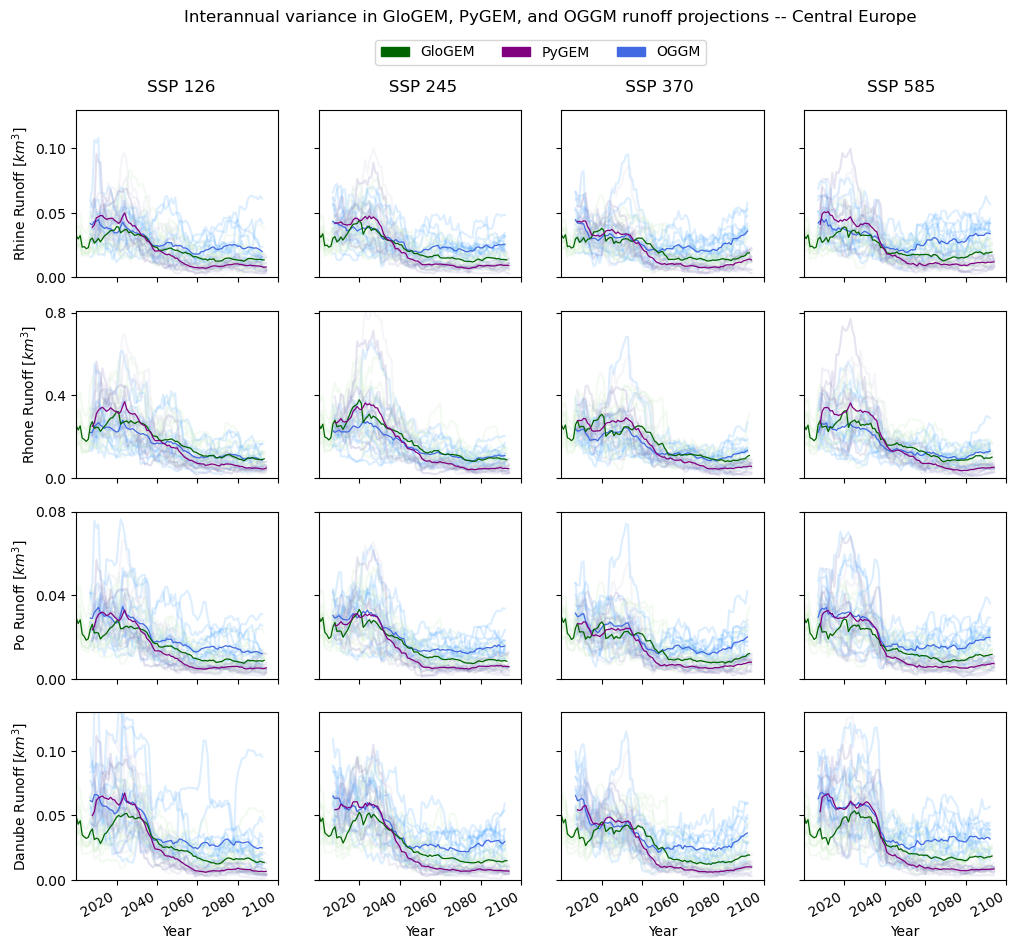

In [289]:
## Same style plot as above; plot rolling variance instead of raw values.  
## Drafted by EHU, modifying multi-GCM runoff plot code from above

rolling_yrs = 15

fig, axs = plt.subplots(len(scenarios), 4, figsize=(12, 10), sharex=True, sharey='row')
for s, SSP in enumerate(scenarios):
    which_ssp = SSPs[s]
    for b, basin in enumerate(basins):

        ## OG won't plot with built-in ds.plot()
        ## Trim last value as it goes to zero
        for m, model in enumerate(modelnames_OG_trimmed):
            axs[b,s].plot(yrs_glo_dt[20:-1], 
                          trimmed_basin_sums_OG[which_ssp][basin][:,0:-1].sel(gcm = modelnames_OG_trimmed[m]).rolling(time=rolling_yrs, center=True).var(), 
                          color = 'dodgerblue', alpha = 0.15)

        ## Trim first value as it is incomplete hydrological year
        for m in modelnames_glo:
            axs[b, s].plot(yrs_glo_dt, basin_sums_glo[which_ssp][basin][m].rolling(window=rolling_yrs, center=True).var(), 
                           color=axs[b, s].set_prop_cycle(glo_cycler), alpha = 0.25)
        axs[b, s].set(xlim=(pd.to_datetime('2000-01-01'), pd.to_datetime('2100-01-01')))

        basin_sums_py[which_ssp][basin].rolling(time=rolling_yrs, center=True).var().plot(hue='model', ax=axs[b, s], color=axs[b, s].set_prop_cycle(py_cycler), alpha = 0.25, add_legend=False)
        axs[b,s].set(title = '')


        ## plot the mean of the variance across all the models - OGGM
        axs[b,s].plot(yrs_glo_dt[20:-1], 
                      trimmed_basin_sums_OG[which_ssp][basin][:,0:-1].rolling(time=rolling_yrs, center=True).var().mean(dim='gcm'), 
                      color = 'royalblue', linewidth = 0.9)
        ## plot the mean of the variance across all the models -- have to create a pandas DF to do this for GloGEM
        axs[b,s].plot(yrs_glo_dt, 
                      pd.DataFrame(basin_sums_glo[which_ssp][basin]).rolling(window=rolling_yrs, center=True).var().mean(axis=1),
                      # GCM_mean_glo[which_ssp][basin], 
                      color = 'darkgreen', linewidth = 0.9)
        ## plot the mean of the variance across all the models - PyGEM        
        basin_sums_py[which_ssp][basin].rolling(time=rolling_yrs, center=True).var().mean(dim='model').plot(ax=axs[b, s], color = 'purple', linewidth = 0.9, add_legend=False)

        ## Setting x and y labels and making y limits uniform within basins
        if b == 3:
            for sub_s in range(4):  # Use a different variable name for the inner loop
                axs[b, sub_s].set_xlabel('Year')
                axs[b, sub_s].set_xticks([pd.to_datetime('2020'),pd.to_datetime('2040'), pd.to_datetime('2060'), pd.to_datetime('2080'), pd.to_datetime('2100')], [2020, 2040, 2060, 2080, 2100])
        else:
            axs[b, s].set_xlabel(None) 
        if b == 0:
            for sub_s in range(4):  # Use a different variable name for the inner loop
                axs[b, sub_s].set_yticks([0.0, 0.05, 0.10]) 
                axs[b, sub_s].set(ylim = (0.,0.13))
        if b == 1:
            for sub_s in range(4): 
        #         y_ticks = [1.0, 2.0, 3.0, 4.0, 5.0]
        #         y_tick_labels = [f'{tick:.1f}' for tick in y_ticks] 
                axs[b, sub_s].set_yticks([0.0, 0.4, 0.8])
        #         axs[b, sub_s].set_yticklabels(y_tick_labels)
                axs[b, sub_s].set(ylim = (0.,0.81))
        if b == 2:                                                                   #Setting y-limits for each basin
            for sub_s in range(4):  
                axs[b, sub_s].set_yticks([0.0, 0.04, 0.08]) 
                axs[b, sub_s].set(ylim = (0.,0.08))
        if b == 3:
            for sub_s in range(4):  
                axs[b, sub_s].set_yticks([0.0, 0.05, 0.10]) 
                axs[b, sub_s].set(ylim = (0.,0.13))
        if s == 0:                                                                    #Setting basin labels
            for sub_b in range(4):
                axs[sub_b,s].set_ylabel(basinstext[sub_b]+ r' Runoff $[km^3]$')
        if s != 0:
            axs[b, s].set_ylabel(None)

green_patch = mpatches.Patch(color='darkgreen', label='GloGEM')
purple_patch = mpatches.Patch(color='purple', label='PyGEM') 
blue_patch = mpatches.Patch(color='royalblue', label='OGGM')
axs[0,0].legend(handles=[green_patch, purple_patch, blue_patch], bbox_to_anchor=(3.15, 1.46), ncol=3)

plt.suptitle('Interannual variance in GloGEM, PyGEM, and OGGM runoff projections -- Central Europe', x=0.52)
plt.title('SSP 126                                 SSP 245                                SSP 370                                 SSP 585', x=-1.3, y=4.66) 

In the plot above, the light lines are single-GCM 15-year rolling variance in runoff, and the darker lines are the mean of 15-year rolling variance across all GCMs.  

## Component from glacier ice loss

#### GloGEM: 

In [290]:
fpath_glogem_vol = '/Volumes/GoogleDrive/My Drive/Runoff-intercomparison/GloGEM-output/Volume/'

all_volumes = [[] for _ in SSPpaths]

for s, SSPpath in enumerate(SSPpaths):
    model_volumes = []
    for modelname in modelnames:
        temp_df = pd.read_csv(fpath_glogem_vol + SSPpaths[s]  + '/' + 'RGIreg11_Volume_individual.dat', sep='\s+', header=0, skiprows=1, index_col=0)
        model_volumes.append(temp_df)
    all_volumes[s] = model_volumes

In [291]:
vol_glogem = {s: {m: None for m in modelnames} for s in SSPpaths} # create nested dictionary indexed by model name and ssp
# n=0
for n,s in enumerate(SSPpaths):
    # i=0
    for i,m in enumerate(modelnames):
        vol_glogem[s][m] = all_volumes[n][i] * 0.9 ## ice volume in km3 to water volume in km3
    #     i+=1
    # n+=1

In [292]:
def sum_basin_vol(basin_RGI_list, vol_data):
    # Create new list to match our RGI formatting
    new_list = [float(s.replace('RGI60-', '')) for s in basin_RGI_list] ## trim leading characters to search this df
    # Filter new_basin_list to keep only the indexes present in the DataFrame
    new_list_trimmed = [x for x in new_list if x in vol_data.index]
    
    # Extract glaciers contained in the list from original df and create a new df
    new_df = vol_data.loc[new_list_trimmed].copy()
    
    # Sum the values of the glaciers within the basin
    summed_basin_vol = new_df.sum()
    #print(summed_basin_runoff)
    
    return summed_basin_vol

In [293]:
#Generating the aggregated basin data
Rhone_vol_gg = {s: {m: None for m in modelnames_glo} for s in SSPpaths} # create nested dictionary indexed by model name and ssp
Rhine_vol_gg = {s: {m: None for m in modelnames_glo} for s in SSPpaths} 
Po_vol_gg = {s: {m: None for m in modelnames_glo} for s in SSPpaths}
Danube_vol_gg = {s: {m: None for m in modelnames_glo} for s in SSPpaths} 

for s in SSPpaths:
    for m in modelnames_glo:
        Rhone_vol_gg[s][m] = sum_basin_vol(select_glaciers_json(alpine_basins['RHONE']), vol_glogem[s][m]) 
        Rhine_vol_gg[s][m] = sum_basin_vol(select_glaciers_json(alpine_basins['RHINE']), vol_glogem[s][m])
        Po_vol_gg[s][m] = sum_basin_vol(select_glaciers_json(alpine_basins['PO']), vol_glogem[s][m]) 
        Danube_vol_gg[s][m] = sum_basin_vol(select_glaciers_json(alpine_basins['DANUBE']), vol_glogem[s][m])

In [294]:
sum(Rhone_vol_gg['ssp126']['BCC-CSM2-MR'] == Rhone_vol_gg['ssp126']['INM-CM5-0']) ## check the volume difference performs okay

121

Wellllll it appears that actually we do not have data for ice volume separated per GCM for GloGEM.  So this was a lot of processing for nothing.  But with luck we can re-use it later, if we get new volume data!

**TODO:** Ask Matthias what the single values of volume are.  Multi-GCM mean, perhaps?

In [295]:
#A quick redefinition that will match PyGEM formatting and make plotting easier later
basins = ['RHINE', 'RHONE', 'PO','DANUBE']
basin_vol_glo = {s: {b: {} for b in basins} for s in SSPpaths}

for s in SSPpaths:
    for m in modelnames_glo:
        basin_vol_glo[s]['RHINE'][m] = Rhine_vol_gg[s][m]
        basin_vol_glo[s]['RHONE'][m] = Rhone_vol_gg[s][m]
        basin_vol_glo[s]['PO'][m] = Po_vol_gg[s][m]
        basin_vol_glo[s]['DANUBE'][m] = Danube_vol_gg[s][m]

# #To calculate multi GCM means and Quartiles we convert to df then calculate across first axis (GCMs)
# GCM_mean_glo = {}
# GCM_q1_glo = {}
# GCM_q3_glo = {}
# for SSP in SSPpaths:
#     GCM_mean_glo[SSP] = {}
#     GCM_q1_glo[SSP] = {}
#     GCM_q3_glo[SSP] = {}
#     for b in basins:
#         GCM_mean_glo[SSP][b] = pd.DataFrame(basin_sums_glo[s][b]).mean(axis=1)
#         GCM_q1_glo[SSP][b] = pd.DataFrame(basin_sums_glo[s][b]).quantile(q=0.25, axis=1)
#         GCM_q3_glo[SSP][b] = pd.DataFrame(basin_sums_glo[s][b]).quantile(q=0.75, axis=1)

In [296]:
basin_vol_glo['ssp126']['RHINE']['BCC-CSM2-MR']

1980    17.74620
1981    17.74620
1982    17.74620
1983    17.74620
1984    17.74620
          ...   
2096     3.23100
2097     3.17565
2098     3.15756
2099     3.11274
2100     3.03804
Length: 121, dtype: float64

In [297]:
basin_vol_glo['ssp126']['RHINE']['BCC-CSM2-MR'].diff()

1980        NaN
1981    0.00000
1982    0.00000
1983    0.00000
1984    0.00000
         ...   
2096   -0.04932
2097   -0.05535
2098   -0.01809
2099   -0.04482
2100   -0.07470
Length: 121, dtype: float64

### PyGEM:

In [298]:
#Importing mass data, taking annual sum, and converting kg to km^3

pymass_ds = {}
for s, SSP in enumerate(SSPs):
    fpath1 = '/mass_annual/R11_mass_annual_c2_ba1_1set_2000_2100-{}'.format(SSP)
    file_pattern = f'{fpathPy + fpath1}*.nc'
    file_list = glob.glob(file_pattern)
    
    datasets = []  # Create an empty list for each SSP
    if file_list:
        for file in file_list:
            with xr.open_dataset(file) as ds:
                ds = ds.glac_mass_annual.load()
                datasets.append(ds)
    
        combined_ds = xr.concat(datasets, dim='glacier')  # Concatenate the datasets
        pymass_ds[SSP] = combined_ds

In [299]:
# Sorting into basins
basin_ds_mass = {} ## still in kg
for basin, glacier_list in basin_gls.items():
    ## loop over them all, drop the irrelevant IDs, and concatenate the result
    basin_ds_mass[basin] = {}
    for s, SSP in enumerate(SSPs):
        ds_list = []
        try:
            ds_filtered = pymass_ds[SSP].where(pymass_ds[SSP].RGIId.isin(glacier_list), drop=True)
            #print(ds_filtered)
            ds_list.append(ds_filtered)
        except ValueError: ## happens if there are no glaciers from this batch in the selected region
            continue
        basin_ds_mass[basin][SSP] = xr.concat(ds_list, dim='glacier')

In [300]:
#Flipping indexing (to match other models) and summing basins
basin_totalmass_py = {}
basin_volkm3_py = {}
for s, SSP in enumerate(SSPs):        
    basin_totalmass_py[SSP] = {}
    basin_volkm3_py[SSP] = {}
    for basin, glacier_list in basin_gls.items():
        basin_totalmass_py[SSP][basin] = basin_ds_vol[basin][SSP].sum(dim='glacier')
        basin_volkm3_py[SSP][basin] = 1e-12 * basin_totalmass_py[SSP][basin] ## in km3
        # basin_volkm3_py[SSP][basin].indexes['year'] = pd.to_datetime(
        #     basin_totalmass_py[SSP][basin].indexes['year'].values, format='%Y') ## trying to correct index right away

In [301]:
basin_ds_mass['RHONE']['ssp126']

<xarray.DataArray 'glac_mass_annual' (model: 12, glacier: 1169, year: 102)>
array([[[1.54321506e+12, 1.50087550e+12, 1.48080360e+12, ...,
         9.82512457e+10, 9.30208376e+10, 9.26673327e+10],
        [1.51597789e+08, 1.28271043e+08, 1.27490451e+08, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.46754792e+08, 2.82837453e+08, 2.82313970e+08, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [2.09590086e+08, 1.79095378e+08, 1.71719364e+08, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [7.88508385e+07, 6.45567196e+07, 6.10958621e+07, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.79341829e+08, 1.46609109e+08, 1.40351316e+08, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[1.56337929e+12, 1.55145860e+12, 1.53894233e+12, ...,
         6.50474137e+10, 6.95907196e+10, 6.52041246e+10],
        [1.51655903e+08, 1.52521257e+08, 1.52327007e+08, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.47238325e+08, 3.46867422e+08, 3.46489894e+08, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
        [2.12211454e+08, 2.04186272e+08, 2.11843311e+08, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [8.02159172e+07, 7.64201205e+07, 7.79894657e+07, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.81612979e+08, 1.74669315e+08, 1.79479681e+08, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[1.56970539e+12, 1.55404311e+12, 1.54257191e+12, ...,
         7.10780861e+10, 7.41522065e+10, 7.70214984e+10],
        [1.52404253e+08, 1.55129878e+08, 1.55806158e+08, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.47421524e+08, 3.55333087e+08, 3.55363672e+08, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [2.13098363e+08, 1.99042042e+08, 2.04649101e+08, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [7.93100852e+07, 7.33921270e+07, 7.38955358e+07, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.82014243e+08, 1.69043309e+08, 1.72374789e+08, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]])
Coordinates:
    RGIId          (glacier) object 'RGI60-11.01238' ... 'RGI60-11.03820'
    Climate_Model  (model) object 'BCC-CSM2-MR' 'CESM2' ... 'NorESM2-MM'
    lon            (glacier) float64 8.396 8.418 8.414 ... 6.419 6.345 6.349
    lat            (glacier) float64 46.62 46.62 46.61 ... 44.95 44.94 44.94
  * model          (model) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * glacier        (glacier) int64 238 299 324 325 326 ... 814 815 816 817 818
  * year           (year) int64 2000 2001 2002 2003 2004 ... 2098 2099 2100 2101
Attributes:
    long_name:            Glacier mass
    unit:                 kg
    temporal_resolution:  annual
    comment:              mass of ice based on area and ice thickness at star...
    grid_mapping:         crs

In [302]:
basin_volkm3_py['ssp126']['RHONE'].diff(dim='year')

<xarray.DataArray 'glac_mass_annual' (model: 12, year: 101)>
array([[-2.27516613, -0.86614333, -0.2326025 , ..., -0.03427218,
        -0.29926521,  0.07255153],
       [-0.44739408, -0.59328753, -0.22723294, ..., -0.12085011,
         0.31049795, -0.28811294],
       [-0.38257298, -1.32834137,  0.11412839, ..., -0.2803549 ,
        -0.07416938, -0.47516738],
       ...,
       [-0.61315659, -0.11650669, -0.49783311, ..., -0.72845802,
         0.09229432,  0.17627591],
       [-0.98372867, -0.35115836,  0.03193453, ..., -0.0427548 ,
        -0.1653062 ,  0.11089077],
       [-0.7589046 , -0.29571067, -1.65777463, ..., -0.08137287,
         0.23971817,  0.14054405]])
Coordinates:
    Climate_Model  (model) object 'BCC-CSM2-MR' 'CESM2' ... 'NorESM2-MM'
  * model          (model) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * year           (year) int64 2001 2002 2003 2004 2005 ... 2098 2099 2100 2101

In [303]:
t_py = pd.to_datetime(basin_volkm3_py['ssp126']['RHONE'].indexes['year'].values, format='%Y')

## make a new index to plot PyGEM with the other models

In [304]:
#Compute multi GCM means and quartiles
GCM_meanvol_py = {}
GCM_q1vol_py = {}
GCM_q3vol_py = {}
for s, SSP in enumerate(SSPs):
    which_ssp = SSPs[s]
    GCM_meanvol_py[which_ssp] = {}
    GCM_q1vol_py[which_ssp] = {}
    GCM_q3vol_py[which_ssp] = {}
    for basin in basins:
        GCM_meanvol_py[which_ssp][basin] = basin_volkm3_py[which_ssp][basin].mean(dim = 'model')
        GCM_q1vol_py[which_ssp][basin] = basin_volkm3_py[which_ssp][basin].quantile(q = 0.25, dim = 'model')
        GCM_q3vol_py[which_ssp][basin] = basin_volkm3_py[which_ssp][basin].quantile(q = 0.75, dim = 'model')

### OGGM volume:

In [305]:
#Importing all volume data, OGGM is grouped by basin
vol_ds_og = {}
for basin, code in alpine_basins.items():
    fpath_basin = 'lschuster/{}'.format(code)
    #print(f'{fpathOG + fpath_basin} (1)/*.nc')
    with xr.open_mfdataset(f'{fpathOG + fpath_basin}/*.nc') as ds:
        ds = ds.volume.load()
    vol_ds_og[basin] = ds

In [306]:
#Summing individual glacier volume into basin totals and converting m3 to km^3
basin_vol_OG = {}
for basin, code in alpine_basins.items():
    basin_vol_OG[basin] = vol_ds_og[basin].sum(dim = 'rgi_id') * 1e-9

In [307]:
#creating dict of GloPy format
basins = ['RHINE', 'RHONE', 'PO', 'DANUBE']
basin_volsums_OG = {}
for s, SSP in enumerate(SSPs):
    which_ssp = SSPs[s]
    basin_volsums_OG[which_ssp] = {}
    for b, basin in enumerate(basins):
        basin_volsums_OG[which_ssp][basin] = basin_vol_OG[basin].sel(scenario = which_ssp)

In [308]:
#Plotting it looks like some GCMs contain all-zero values, like:
basin_volsums_OG['ssp126']['DANUBE'][14]

<xarray.DataArray 'volume' (time: 101)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)
Coordinates:
  * time             (time) float64 2e+03 2.001e+03 ... 2.099e+03 2.1e+03
    scenario         <U6 'ssp126'
    gcm              <U7 'TaiESM1'
    hydro_year       (time) int64 2000 2001 2002 2003 ... 2097 2098 2099 2100
    hydro_month      (time) int64 4 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4 4
    calendar_year    (time) int64 2000 2001 2002 2003 ... 2097 2098 2099 2100
    calendar_month   (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    bias_correction  <U12 'bc_2000_2019'

In [309]:
#Removing these GCMs for ALL SSPs--doing even 585 as these two are not included...
#... in Glo or Py so not only makeds OOGM easier but maintains GCM consistency in analysis
trimmed_basin_volsums_OG = {}
for s, SSP in enumerate(SSPs):
    which_ssp = SSPs[s]
    trimmed_basin_volsums_OG[which_ssp] = {}
    for b, basin in enumerate(basins):
        trimmed_basin_volsums_OG[which_ssp][basin] = xr.concat([basin_volsums_OG[which_ssp][basin][0:4], 
                                                                basin_volsums_OG[which_ssp][basin][5:-1]], dim='gcm')
        

In [310]:
#Compute multi GCM means and quartiles for OGGM
GCM_meanvol_OG = {}
GCM_q1vol_OG = {}
GCM_q3vol_OG = {}
for s, SSP in enumerate(SSPs):
    which_ssp = SSPs[s]
    GCM_meanvol_OG[which_ssp] = {}
    GCM_q1vol_OG[which_ssp] = {}
    GCM_q3vol_OG[which_ssp] = {}
    for basin in basins:
        GCM_meanvol_OG[which_ssp][basin] = trimmed_basin_volsums_OG[which_ssp][basin].mean(dim = 'gcm')
        GCM_q1vol_OG[which_ssp][basin] = trimmed_basin_volsums_OG[which_ssp][basin].quantile(q = 0.25, dim = 'gcm')
        GCM_q3vol_OG[which_ssp][basin] = trimmed_basin_volsums_OG[which_ssp][basin].quantile(q = 0.75, dim = 'gcm')

In [311]:
trimmed_basin_volsums_OG['ssp126']['RHONE'].diff(dim='time')

<xarray.DataArray 'volume' (gcm: 13, time: 100)>
array([[-2.0252609e+00, -6.3389969e-01, -1.0337067e-01, ...,
         4.8341751e-03, -3.1769753e-02, -4.5779800e-01],
       [-2.2171021e-02, -1.2257652e+00, -8.9526367e-01, ...,
        -9.3448639e-02, -5.7520485e-01, -8.2526016e-01],
       [-3.4729004e-01, -1.0358353e+00, -2.8098297e-01, ...,
         9.6416473e-04, -1.4049053e-01,  3.8736057e-01],
       ...,
       [-5.2529907e-01,  6.0966492e-02, -6.2711334e-01, ...,
         5.4103851e-02, -1.0624828e+00, -3.2997131e-03],
       [-8.4144592e-01, -1.7528152e-01,  1.3804245e-01, ...,
        -1.8955326e-01, -9.9093437e-02, -1.7636585e-01],
       [-8.4969330e-01, -1.1954498e-01, -1.6403542e+00, ...,
         3.4283638e-02, -8.3166599e-02,  3.2426786e-01]], dtype=float32)
Coordinates:
  * time             (time) float64 2.001e+03 2.002e+03 ... 2.099e+03 2.1e+03
    scenario         <U6 'ssp126'
  * gcm              (gcm) object 'BCC-CSM2-MR' 'CAMS-CSM1-0' ... 'NorESM2-MM'
    hydro_year       (time) int64 2001 2002 2003 2004 ... 2097 2098 2099 2100
    hydro_month      (time) int64 4 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4 4
    calendar_year    (time) int64 2001 2002 2003 2004 ... 2097 2098 2099 2100
    calendar_month   (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    bias_correction  <U12 'bc_2000_2019'

Text(-1.3, 4.66, 'SSP 126                                 SSP 245                                SSP 370                                 SSP 585')

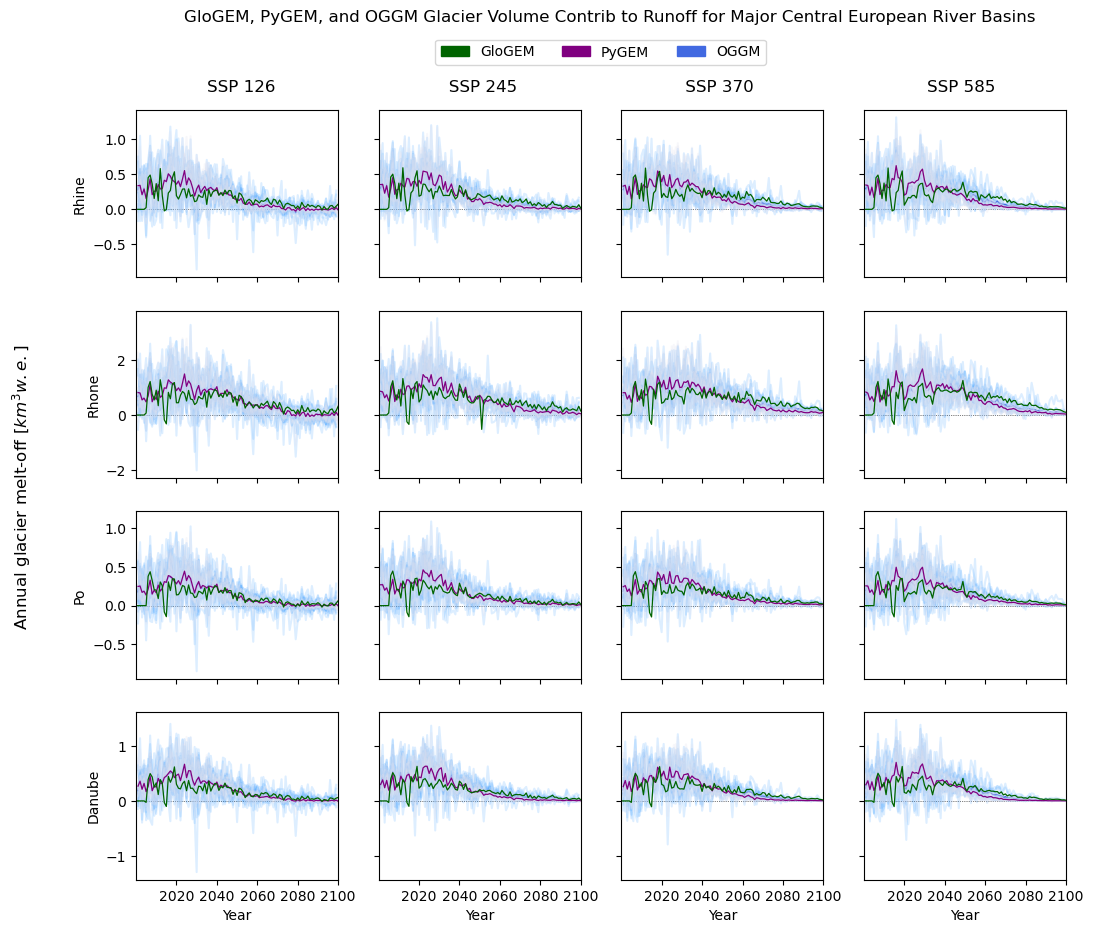

In [312]:
#Plot volume in similar style

fig, axs = plt.subplots(len(scenarios), 4, figsize=(12, 10), sharex=True, sharey='row')
for s, SSP in enumerate(scenarios):
    which_ssp = SSPs[s]
    for b, basin in enumerate(basins):
        axs[b,s].axhline(y=0, ls=':', color='k', lw=0.5) ## mark pos/neg
        
        #OG won't plot with built-in ds.plot()
        #Trim last value as it goes to zero
        for m, model in enumerate(modelnames_OG_trimmed):
            axs[b,s].plot(yrs_glo_dt[21:-1], 
                          -1*trimmed_basin_volsums_OG[which_ssp][basin][:,0:-1].diff(dim='time').sel(gcm = modelnames_OG_trimmed[m]), 
                          color = 'dodgerblue', alpha = 0.15)
        axs[b,s].plot(yrs_glo_dt[21:-1], -1*GCM_meanvol_OG[which_ssp][basin][0:-1].diff(dim='time'), color = 'royalblue', linewidth = 0.9)
#         axs[b,s].plot(yrs_glo_dt[20:-1], GCM_q1_OG[which_ssp][basin][0:-1], color = 'royalblue', linewidth = 0.4)
#         axs[b,s].plot(yrs_glo_dt[20:-1], GCM_q3_OG[which_ssp][basin][0:-1], color = 'royalblue', linewidth = 0.4)
#         axs[b,s].fill_between(yrs_glo_dt[20:-1], GCM_q1_OG[which_ssp][basin][0:-1], GCM_q3_OG[which_ssp][basin][0:-1], color = 'dodgerblue', alpha = 0.5)


        ## Plot PyGEM
        for j in range(1,13): ## these are selected only by number, not by name
            axs[b, s].plot(t_py[1::], -1*basin_volkm3_py[SSP][basin].diff(dim='year').sel(model=j),
                           color=axs[b, s].set_prop_cycle(py_cycler), alpha = 0.25)
        axs[b,s].plot(t_py[1::], -1*GCM_meanvol_py[which_ssp][basin].diff(dim='year'),
                      color = 'purple', linewidth = 0.9)
#         # GCM_meanvol_py[which_ssp][basin].plot(hue='model', ax=axs[b, s], color = 'purple', linewidth = 0.9, add_legend=False)
#         # GCM_q1vol_py[which_ssp][basin].plot(hue='model', ax=axs[b, s], color = 'purple', linewidth = 0.4, add_legend=False)
#         # GCM_q3vol_py[which_ssp][basin].plot(hue='model', ax=axs[b, s], color = 'purple', linewidth = 0.4, add_legend=False)
#         # axs[b,s].fill_between(yrs_glo_dt[20::], GCM_q1_py[which_ssp][basin], GCM_q3_py[which_ssp][basin], color = 'Purple')
#         # axs[b,s].set(title = '')
        
        # ## Plot GloGEM -- in front for now, as only one
        axs[b, s].plot(yrs_glo_dt, -1*basin_vol_glo[which_ssp][basin]['CESM2'].diff(),  ## all models the same, just choose CESM
                           # color=axs[b, s].set_prop_cycle(glo_cycler), alpha = 0.25,
                           color='darkgreen', linewidth=0.9
                          )
#         # # # axs[b,s].plot(yrs_glo_dt, GCM_mean_glo[which_ssp][basin], color = 'darkgreen', linewidth = 0.9)
#         # # # axs[b,s].plot(yrs_glo_dt, GCM_q1_glo[which_ssp][basin], color = 'darkgreen', linewidth = 0.4)
#         # # # axs[b,s].plot(yrs_glo_dt, GCM_q3_glo[which_ssp][basin], color = 'darkgreen', linewidth = 0.4)
#         # # # axs[b,s].fill_between(yrs_glo_dt, GCM_q1_glo[which_ssp][basin], GCM_q3_glo[which_ssp][basin], color = 'green')
        axs[b, s].set(xlim=(pd.to_datetime('2000-01-01'), pd.to_datetime('2100-01-01')))

        #Setting x and y labels and making y limits uniform within basins
        if b == 3:
            for sub_s in range(4):  # Use a different variable name for the inner loop
                axs[b, sub_s].set_xlabel('Year')
                axs[b, sub_s].set_xticks([pd.to_datetime('2020'),pd.to_datetime('2040'), 
                                          pd.to_datetime('2060'), pd.to_datetime('2080'), pd.to_datetime('2100')], 
                                         [2020, 2040, 2060, 2080, 2100])
        else:
            axs[b, s].set_xlabel(None) 
#         if b == 0:
#             for sub_s in range(4):  # Use a different variable name for the inner loop
#                 axs[b, sub_s].set_yticks([0.5, 1.0, 1.5, 2.0, 2.5]) 
#                 axs[b, sub_s].set(ylim = (0.4,2.6))
#         if b == 1:
#             for sub_s in range(4): 
#                 y_ticks = [1.0, 2.0, 3.0, 4.0, 5.0]
#                 y_tick_labels = [f'{tick:.1f}' for tick in y_ticks] 
#                 axs[b, sub_s].set_yticks(y_ticks)
#                 axs[b, sub_s].set_yticklabels(y_tick_labels)
#                 axs[b, sub_s].set(ylim = (0.8,5.5))
#         if b == 2:                                                                   #Setting y-limits for each basin
#             for sub_s in range(4):  
#                 axs[b, sub_s].set_yticks([0.5, 1.0, 1.5, 2.0]) 
#                 axs[b, sub_s].set(ylim = (0.3,2.1))
#         if b == 3:
#             for sub_s in range(4):  
#                 axs[b, sub_s].set(ylim = (0.4,2.6))
        if s == 0:                                                                    #Setting basin labels
            for sub_b in range(4):
                axs[sub_b,s].set_ylabel(basinstext[sub_b])
        if s != 0:
            axs[b, s].set_ylabel(None)

green_patch = mpatches.Patch(color='darkgreen', label='GloGEM')
purple_patch = mpatches.Patch(color='purple', label='PyGEM') 
blue_patch = mpatches.Patch(color='royalblue', label='OGGM')
axs[0,0].legend(handles=[green_patch, purple_patch, blue_patch], bbox_to_anchor=(3.15, 1.46), ncol=3)

plt.suptitle('GloGEM, PyGEM, and OGGM Glacier Volume Contrib to Runoff for Major Central European River Basins', x=0.52)
fig.supylabel(r' Annual glacier melt-off $[km^3 w.e.]$')
plt.title('SSP 126                                 SSP 245                                SSP 370                                 SSP 585', x=-1.3, y=4.66) 